smart_hans_07312022_173453_4_131-155_08_mnn_.csv
smart_hans_07312022_171736_10_271-296_08_mnn_.csv
smart_hans_08022022_211852_10_341-371_08_mky_.csv
smart_hans_07312022_182331_4_149-180_08_wnn_.csv
smart_hans_08022022_190740_9_301-331_08_mny_.csv
smart_hans_07312022_181701_7_243-273_08_wny_.csv
smart_hans_07252022_154619_12_431-469_08_mgy_.csv
smart_hans_08022022_192941_6_217-247_08_wny_.csv
smart_hans_07312022_173105_12_400-431_08_mnn_.csv
smart_hans_07312022_175436_12_339-368_08_mny_.csv
smart_hans_08022022_192131_8_280-310_08_wny_.csv
smart_hans_07312022_161925_10_313-339_08_mny_.csv
smart_hans_08022022_191248_9_307-336_08_mny_.csv
smart_hans_08022022_192219_4_154-184_08_wny_person_hat_nach_12_gewackelt.csv
smart_hans_08022022_174636_13_433-463_08_wyn_.csv
smart_hans_07312022_170216_4_149-178_08_mgy_furz_lachen_am_ende.csv
smart_hans_08022022_195007_9_312-344_08_gny_.csv
smart_hans_08022022_194923_10_343-374_08_gny_.csv
smart_hans_08022022_192033_4_152-183_08_wny_.csv
smart_hans_080

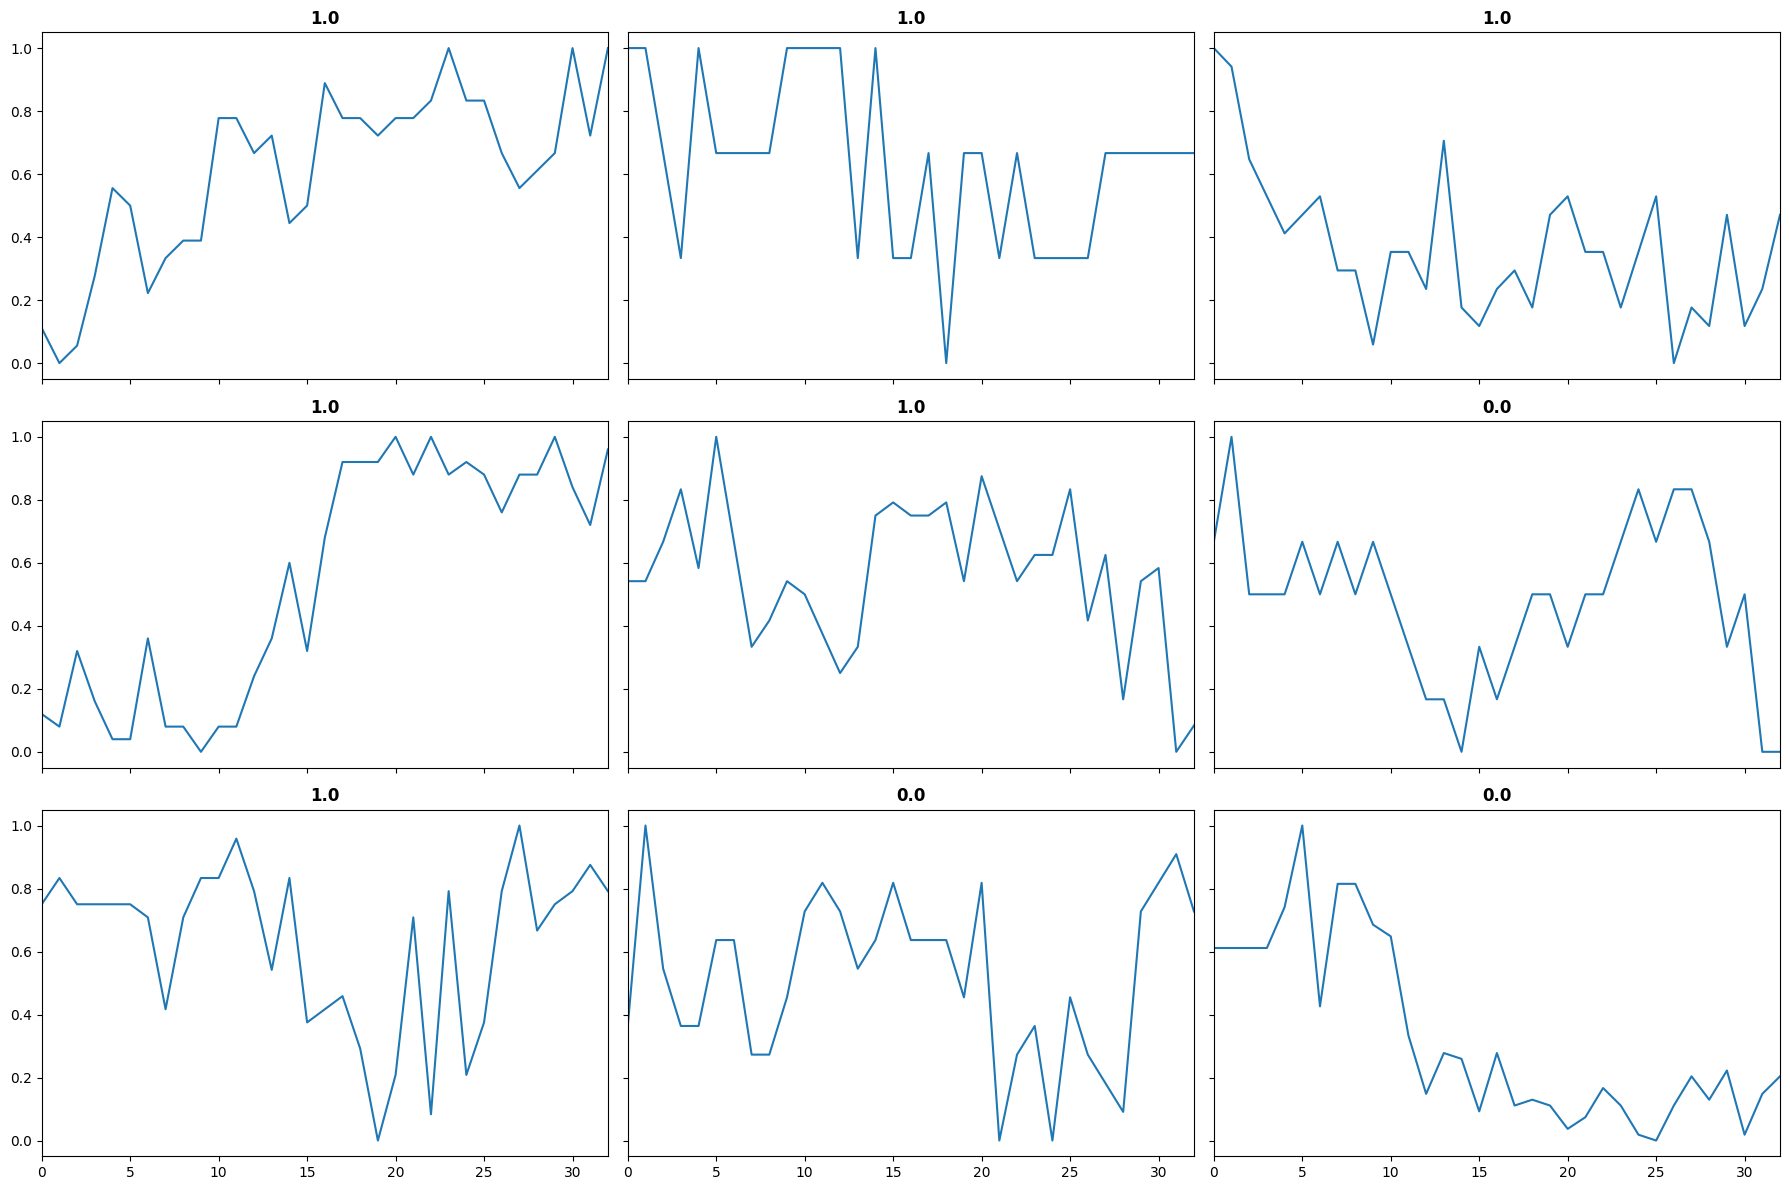

In [449]:
from tsai.all import *
import pandas as pd
from datenverarbeitung.dataloader import dataloader
import datetime
CUDA_LAUNCH_BLOCKING=1



num_scenario = 3
nr_taps = 1
tap_size = 33
move_by = -3
#batch_size = 1 
learning_cycles = 25
model_to_use = "InceptionTimePlus"
features_to_learn_with = ["right_eye_corner_y"]
feature_list_string = '_'.join(features_to_learn_with)

models_folder = "models"
plots_folder = "vis/plots"
save_name = "scenario_{}_{}".format(num_scenario, model_to_use)

dl = dataloader(scenario= num_scenario, path="/home/adi/cloudy_adlu/smart_hans/AP2/Daten/zum_sichten/laeuft", nr_taps=nr_taps, move_window_by=move_by, tap_size=tap_size, feature_list=features_to_learn_with)
train, test= dl.train, dl.test

X_test, y_test = df2xy(test, target_col='target')
X_train, y_train = df2xy(train, target_col='target')

X, y, splits = combine_split_data([X_train, X_test], [y_train, y_test])

tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
dsets

dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid,  num_workers=0)

dls.show_batch(sharey=True)

In [450]:

scenario_name_stage0 = save_name+"_nr_taps_{}_features_{}".format(str(nr_taps), feature_list_string)+"_stage0"
model = InceptionTimePlus(dls.vars, dls.c, tap_size)
learn = Learner(dls, model, metrics=accuracy, lr=0.001)
learn.save(scenario_name_stage0)

Path('models/scenario_3_InceptionTimePlus_nr_taps_1_features_right_eye_corner_y_stage0.pth')

SuggestedLRs(valley=0.00015848931798245758)

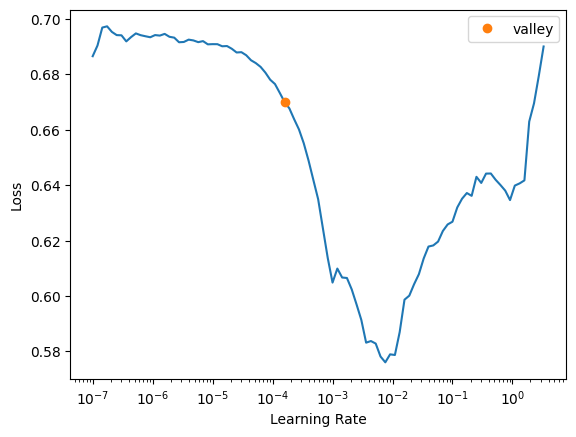

In [451]:
learn.load(scenario_name_stage0)
learn.lr_find(start_lr=1e-07, end_lr=10, num_it=100, stop_div=True, show_plot=True)


In [452]:
learn.lr = 0.0001
#learn.fine_tune(1)

In [453]:
scenario_name_stage1 = scenario_name_stage0.replace("0","1")

learn.fit_one_cycle(learning_cycles,lr_max=1e-4)

learn.save(scenario_name_stage1)
#learn.save_all(path='export', dls_fname='dls', model_fname='model', learner_fname='learner')

epoch,train_loss,valid_loss,accuracy,time
0,0.691494,0.692791,0.517647,00:01
1,0.690548,0.692495,0.517647,00:00
2,0.687899,0.692426,0.517647,00:00
3,0.681255,0.692694,0.505882,00:00
4,0.672905,0.693118,0.494118,00:00
5,0.661149,0.693514,0.505882,00:00
6,0.647433,0.693582,0.505882,00:00
7,0.632215,0.693656,0.505882,00:00
8,0.614616,0.694176,0.505882,00:00
9,0.595446,0.695404,0.505882,00:00


Path('models/scenario_3_InceptionTimePlus_nr_taps_1_features_right_eye_corner_y_stage1.pth')

In [454]:
#

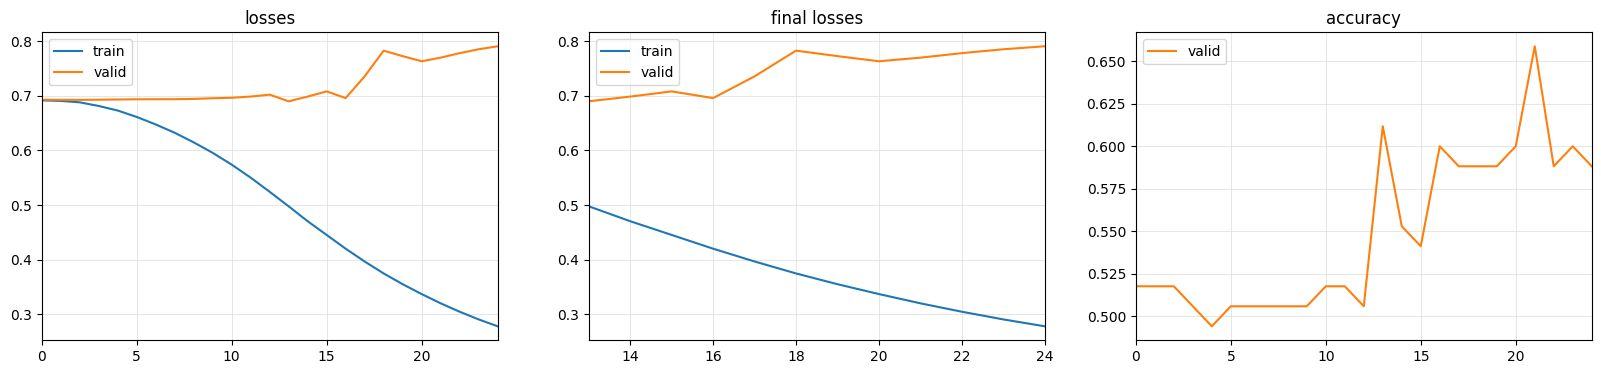

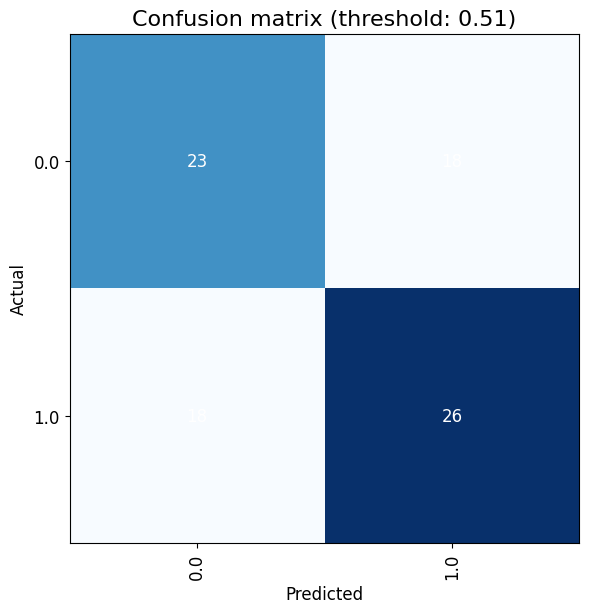

In [455]:
learn.recorder.plot_metrics()
learn.plot_confusion_matrix(thr=0.51)
feature_list_string = '_'.join(features_to_learn_with)
current_time= datetime.datetime.now().strftime('%d%m%Y_%H%M%S')
plot_name = plots_folder+"/confusion_matrix_"+save_name+"_nrtaps_{}_features_{}_learning_cycles_{}_{}.png".format(str(nr_taps),feature_list_string,learning_cycles, current_time)

#plt.savefig(plot_name, ext='png', bbox_inches="tight")

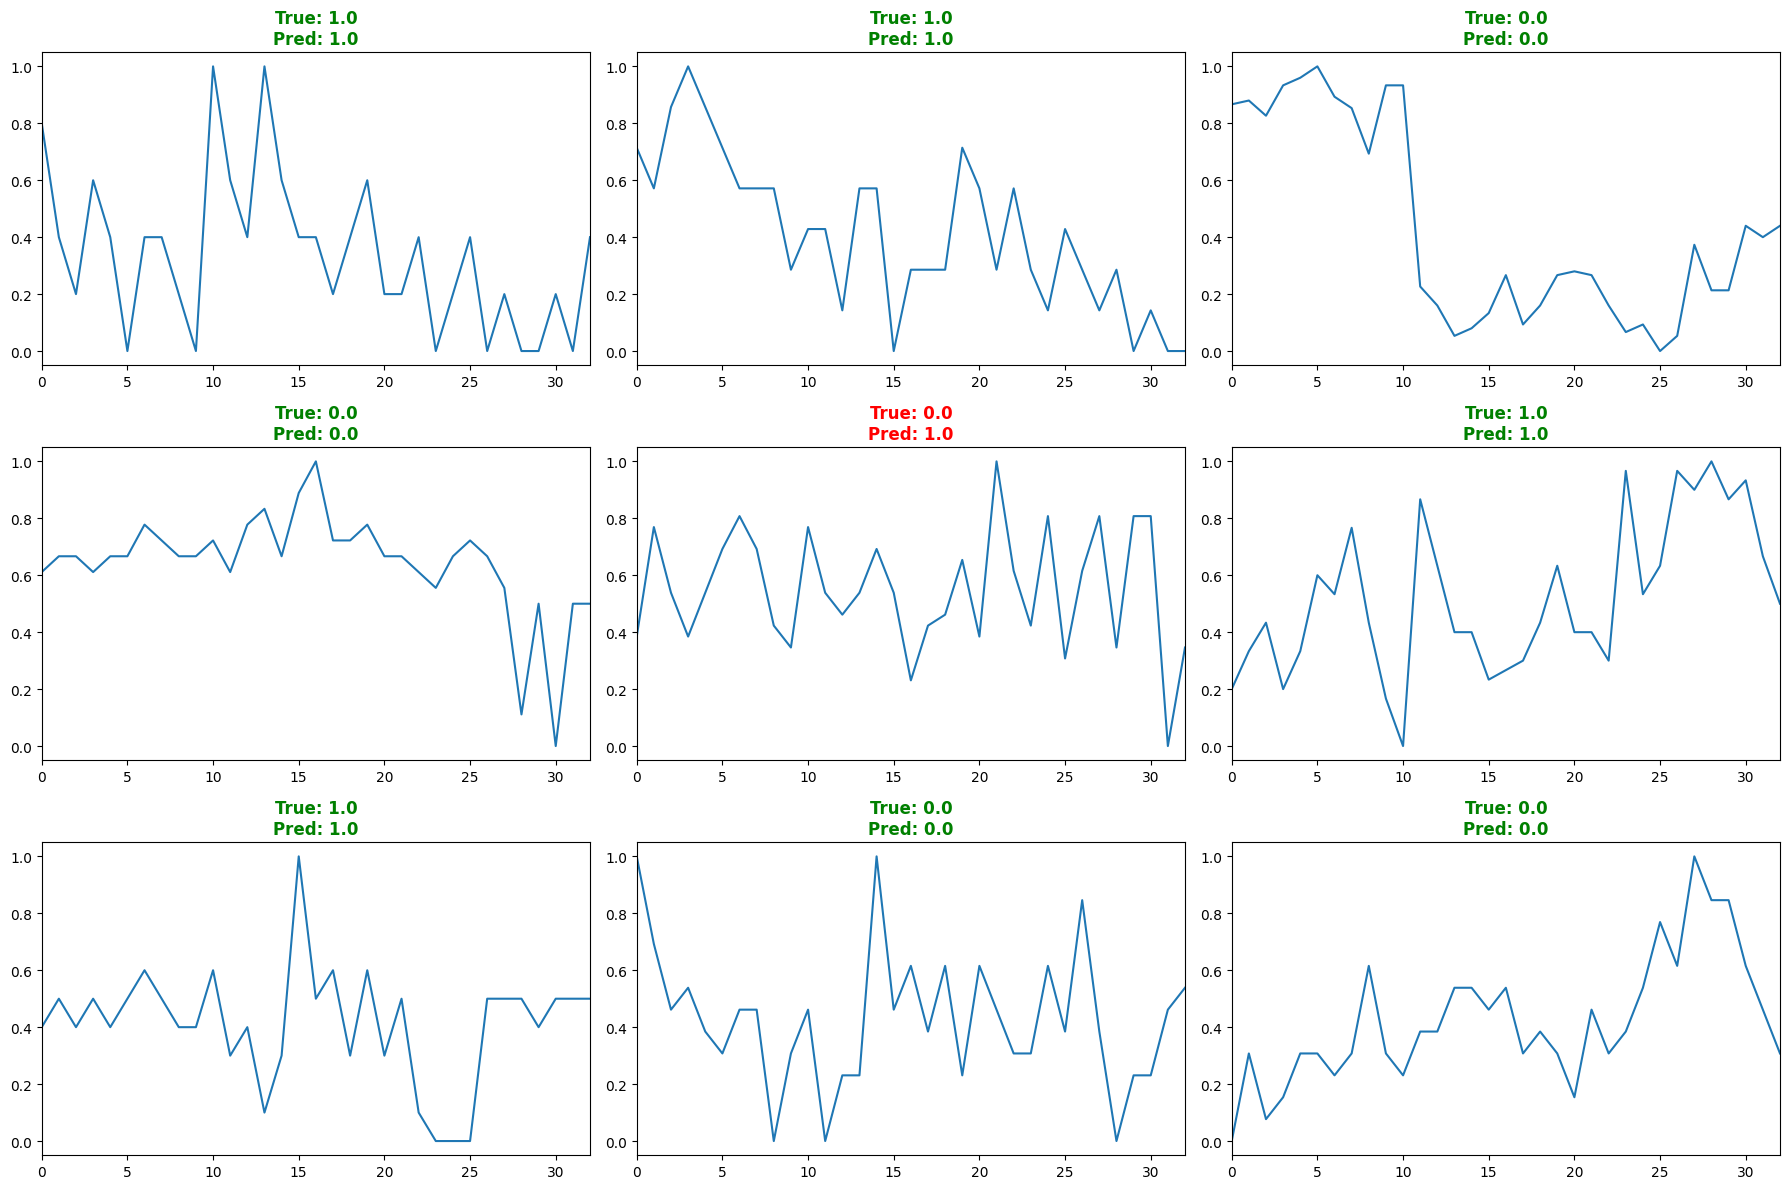

In [456]:
learn.show_results()

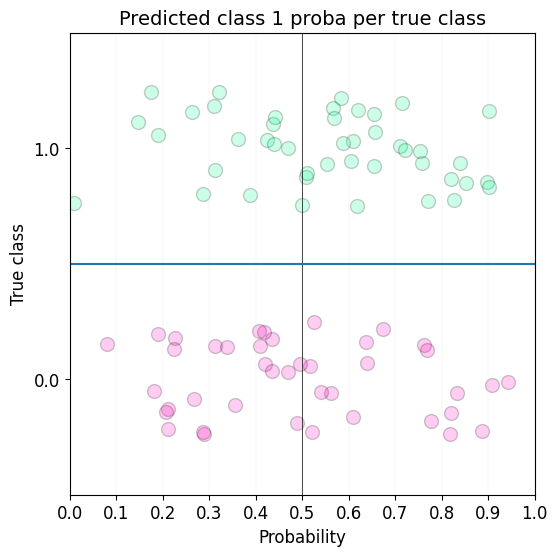

In [457]:
learn.show_probas()
#was sagt probability aus? accuracy vs probability?